In [5]:
!pip install catboost

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from CatBoostModel import CatBoost_model
from metrics import root_mean_squared_error, mean_absolute_percentage_error
from preprocessor import Preprocessor

sns.set(font_scale=1.5)
%matplotlib inline

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using Tesla K80 GPUs


In [0]:
DATA_PATH = "/content/drive/My Drive/HobbyTaste/data/nasdaq100_padding.csv"
D_size=5

In [0]:
df = pd.read_csv(DATA_PATH)

In [11]:
preproc = Preprocessor(
    dataset=df.iloc[:40000, :].to_numpy(),
    device=device,
)
preproc.scale()
preproc.train_val_test_split(
    train_size=30000,
    val_size=5000,
    use_tqdm=True,
)

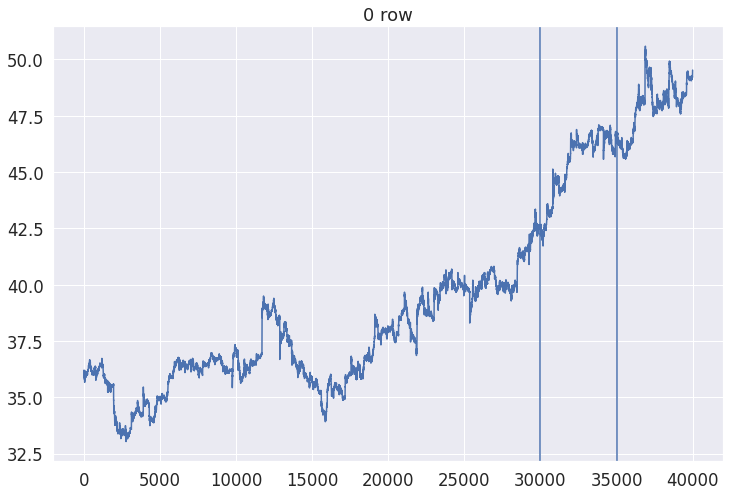

In [12]:
preproc.plot_dataset(0)

In [0]:
cbr = CatBoost_model(
    use_gpu=False,
    loss_function='RMSE',
    multi_target=False,
    params={'iterations':2000,},
)

In [14]:
cbr.train_union(
    X_train=preproc.get_data(
        name='X_train',
        torch_tensor=False,
        to_device=False
    ),
    y_train=preproc.get_data(
        name='y_train',
        torch_tensor=False,
        to_device=False
    ),
    train_horizon=30,
    row_ind=0,
)

Learning rate set to 0.042223
0:	learn: 0.0010345	total: 112ms	remaining: 3m 44s
100:	learn: 0.0009965	total: 5.85s	remaining: 1m 50s
200:	learn: 0.0009665	total: 11.6s	remaining: 1m 44s
300:	learn: 0.0009414	total: 17.3s	remaining: 1m 37s
400:	learn: 0.0009162	total: 22.8s	remaining: 1m 30s
500:	learn: 0.0008936	total: 28.4s	remaining: 1m 25s
600:	learn: 0.0008715	total: 34s	remaining: 1m 19s
700:	learn: 0.0008499	total: 39.7s	remaining: 1m 13s
800:	learn: 0.0008302	total: 45.4s	remaining: 1m 7s
900:	learn: 0.0008116	total: 51.1s	remaining: 1m 2s
1000:	learn: 0.0007945	total: 56.8s	remaining: 56.7s
1100:	learn: 0.0007775	total: 1m 2s	remaining: 51.1s
1200:	learn: 0.0007614	total: 1m 8s	remaining: 45.5s
1300:	learn: 0.0007458	total: 1m 14s	remaining: 39.9s
1400:	learn: 0.0007316	total: 1m 20s	remaining: 34.2s
1500:	learn: 0.0007174	total: 1m 25s	remaining: 28.5s
1600:	learn: 0.0007034	total: 1m 31s	remaining: 22.9s
1700:	learn: 0.0006904	total: 1m 37s	remaining: 17.2s
1800:	learn: 0.00

In [0]:
pred, gt = cbr.pred_union(
    X_data=preproc.get_data(
        name='X_val',
        torch_tensor=False,
        to_device=False
    ),
    y_data=preproc.get_data(
        name='y_val',
        torch_tensor=False,
        to_device=False
    ),
    horizon_pred_out=1,
)

Попробуем посмотреть на предсказания. Т.к. предсказывали разности логафримов, возьмем кумулятивные суммы, а затем экспоненту.(Возможно стоит сделать класс постпроцессинга)


In [0]:
predictions = np.exp(
    np.concatenate(
        ([[np.log(preproc.raw_dataset[preproc.train_size, 0])]], pred)
    ).cumsum(axis=0)
)

In [0]:
test = np.exp(
    np.concatenate(
        ([[np.log(preproc.raw_dataset[preproc.train_size, 0])]], gt)
    ).cumsum(axis=0)
)

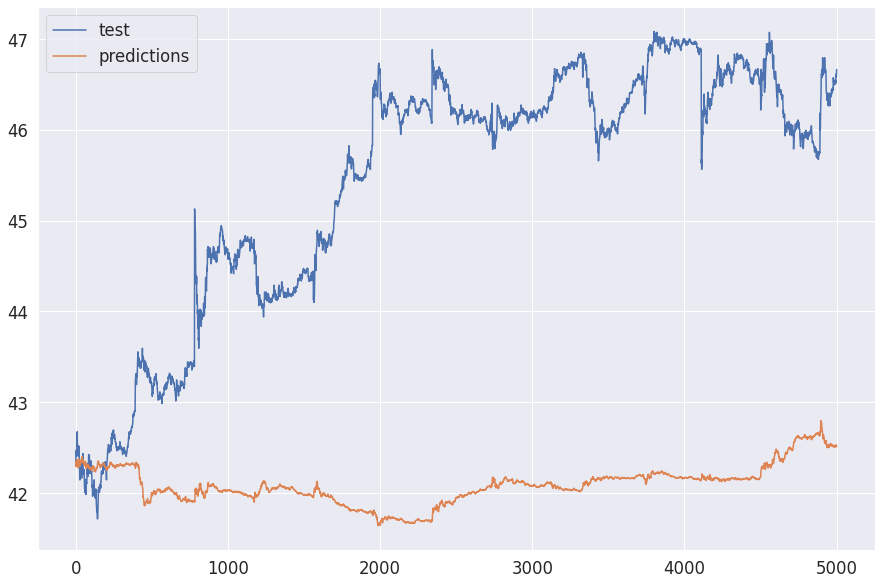

In [18]:
plt.figure(figsize=(15, 10))
plt.plot(test, label='test')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

Поcмотрим на метркии


In [19]:
root_mean_squared_error(
    test,
    predictions
)

3.628339655681153

In [21]:
mean_absolute_percentage_error(
    test,
    predictions
)

7.293262767983679

Как видим, преобразование Бокса-Кокса и дифференцирование позволило нам сделать адекватное предсказание с использованием CatBoost. Тем не менее, исходя из графиком вы видим значительные расхождени в долгосрочной перспективе.